#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Rootfinding

Rootfinding is the process of solving $$f(x) = 0$$ for $x$.  The standard assumption is that $f : R \to R$ is _continuous_.  We are interested in developing general-purpose algorithms---those that can use $f(x)$ as a black box without needing to look inside.  When we implement our rootfinding algorithm in software, the user will pass a function or program to compute $f(x)$.  Rootfinding methods for differentiable functions may also use the derivative $f'(x)$.

Some questions immediately arise:
* **Existence.** When does this equation have at least one solution?
* **Uniqueness.** When is the solution unique?

Let's consider some test functions, defined here along with their derivatives which we'll use later.

<IPython.core.display.Javascript object>


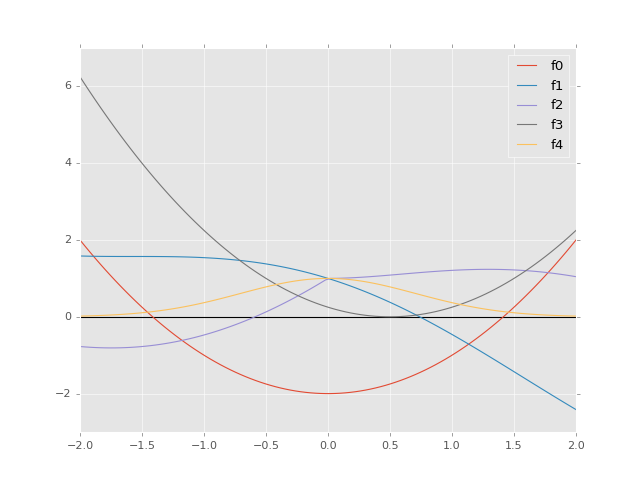

In [65]:
%matplotlib notebook
import numpy

tests = []

@tests.append
def f0(x):
    return x*x - 2, 2*x

@tests.append
def f1(x):
    return numpy.cos(x) - x, -numpy.sin(x) - 1

@tests.append
def f2(x):
    return numpy.exp(-numpy.abs(x)) + numpy.sin(x), numpy.exp(-numpy.abs(x))*(-numpy.sign(x)) + numpy.cos(x)

@tests.append
def f3(x):
    return x*x - x + .25, 2*x - 1

@tests.append
def f4(x):
    return numpy.exp(-x*x), numpy.exp(-x*x)*(-2*x)

x = numpy.linspace(-2,2,100)
pyplot.plot(x, 0*x, color='k')
for f in tests:
    pyplot.plot(x, f(x)[0], label=f.__name__)
pyplot.legend(loc='upper right')
pyplot.style.use('ggplot')
pyplot.show()

* Which of these functions have at least one root?
* Which have more than one root?
* Can we determine these properties merely by evaluating $f(x)$ for some values of $x$?

## Bisection

Bisection is a rootfinding technique that starts with an interval $[a,b]$ containing a root and does not require derivatives.

In [53]:
def hasroot(f, a, b):
    return f(a)[0]*f(b)[0] < 0
    
def bisect(f, a, b, verbose=False):
    mid = (a + b)/2.
    if b-a < 1e-5:
        return mid
    if verbose:
        print('bisect', mid)
    if hasroot(f, a, mid):
        return bisect(f, a, mid, verbose)
    else:
        return bisect(f, mid, b, verbose)

* Notice that we need to define `hasroot` above.

Let's try running it:

In [54]:
bisect(tests[0], 0, 2)

1.4142112731933594

In [35]:
numpy.sqrt(2)

1.4142135623730951

We get about 5 digits of accuracy.  Why?  How fast did we get there?

In [55]:
bisect(tests[0], 0, 2, verbose=True)

bisect 1.0
bisect 1.5
bisect 1.25
bisect 1.375
bisect 1.4375
bisect 1.40625
bisect 1.421875
bisect 1.4140625
bisect 1.41796875
bisect 1.416015625
bisect 1.4150390625
bisect 1.41455078125
bisect 1.414306640625
bisect 1.4141845703125
bisect 1.41424560546875
bisect 1.414215087890625
bisect 1.4141998291015625
bisect 1.4142074584960938


1.4142112731933594

Can you find any problems with this implementation?  List them below:

* ...

Let's try running it on the rest of the test problem set:

In [56]:
for f in tests:
    print(f.__name__, bisect(f, -2, 2))

f0 -1.4142112731933594
f1 0.7390861511230469
f2 -0.5885353088378906
f3 1.9999961853027344
f4 1.9999961853027344


What's going wrong here?  How can we improve the implementation and what are fundamental limitations of the algorithm?

### Convergence rate

Let's quantitatively revisit the convergence rate.  A convergent rootfinding algorithm produces a sequence of approximations $x_i$ such that $$\lim_{i \to \infty} x_i \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_i = x_i - x_*$. We say that an algorithm is **linearly convergent** if $$\lim_{i \to \infty} |e_{i+1}| / |e_i| = \rho < 1.$$  A smaller convergence factor $\rho$ represents faster convergence.

What is $\rho$ for bisection?

### Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* Roots of even degree are problematic
* The solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy

## Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \dotsb $$
centered on some reference point $x_0$.
In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

In [88]:
def newton(f, x):
    for i in range(100):
        fx, dfx = f(x)
        if numpy.abs(fx) < 1e-12:
            return x, fx, i
        x -= fx / dfx

for f in tests:
    print(f.__name__, newton(f, 0))

ZeroDivisionError: division by zero

* Oops, how can we fix this?
* This output is kinda hard to read, so let's make it cleaner.

In [87]:
for f in tests:
    print(f.__name__, '{0:15.12f} {1:8.2e} {2:2d}'.format(*newton(f, -0.1)))

f0 -1.414213562373 1.33e-15  8
f1  0.739085133215 0.00e+00  5
f2 -0.588532743981 5.55e-13  4
f3  0.499999427800 3.27e-13 20
f4 -5.294229332623 6.72e-13  3


* Did we solve all of these equations?
* Does choosing a different initial guess lead to different solutions?
* How is this convergence test different from the one we used for bisection?